In [1]:
import torch
torch.utils.cpp_extension.get_compiler_abi_compatibility_and_version()

: 

In [1]:
import torch
#from pylab import figure, cm
import matplotlib.pyplot as plt
import numpy as np

torch.pi = torch.acos(torch.zeros(1)).item() * 2
x = torch.linspace(0, 1, 100)
y = torch.linspace(0, 1, 100)
X, Y = torch.meshgrid(x, y)
noise = torch.normal(0, 0.1, size=(len(x), len(y)))

def f(x, y):
    return torch.sin(2 * torch.pi * (x + y)) #+ noise

def dfdx(x, y):
    return 2 * torch.pi * torch.cos(2 * torch.pi * (x + y))

def ddfddx(x, y):
    return -4 * (torch.pi ** 2) * torch.sin(2 * torch.pi * (x + y))

print('f(x,y) = ', f(X, Y))
print('dfdx = ', dfdx(X, Y))
print('ddfddx = ', ddfddx(X, Y))

X.requires_grad_(True)
Y.requires_grad_(True)

z = f(X, Y).sum()
z.backward(create_graph=True)

partial_x = X.grad
partial_y = Y.grad

partial_x2 = torch.autograd.grad(partial_x.sum(), X, create_graph=True)[0]

print('autograd dfdx = ', partial_x)
#print(partial_x == partial_y)

X1 = X.detach()
Y1 = Y.detach()

partial_x0 = partial_x.detach()
partial_x1 = partial_x2.detach()


plt.title('Функция sin(2*pi*(x + y))')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(f(X1, Y1), extent=[0,1,0,1])
plt.colorbar()
plt.show()
plt.title('Аналитическая первая 2*pi*cos(2*pi*(x + y))')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(dfdx(X1, Y1), extent=[0,1,0,1])
plt.colorbar()
plt.show()
plt.title('Autograd первая')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(partial_x0, extent=[0,1,0,1])
plt.colorbar()
plt.show()
""""
plt.title('Аналитическая вторая-4*pi^2*sin(2*pi*(x + y))')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(ddfddx(X1, Y1),extent=[0,1,0,1], cmap=cm.jet, origin='lower')
plt.colorbar()
plt.show()
plt.title('Autograd вторая')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(partial_x1,extent=[0,1,0,1], cmap=cm.jet, origin='lower')
plt.colorbar()
plt.show()
"""



: 

In [82]:
import numpy as np

partial_x1 = partial_x0.numpy()
np.save('x300', partial_x1)

x300 = np.load('x300.npy')



In [3]:
import torch
from torch import nn
from typing import Any, Union, List, Tuple
import numpy as np
from scipy import linalg
from pylab import figure, cm
import matplotlib.pyplot as plt

def _nn_autograd(model: torch.nn.Module,
                     points: torch.Tensor,
                     var: int,
                     axis: List[int] = [0]):
        """ Computes derivative on the grid using autograd method.

        Args:
            model (torch.nn.Module): torch neural network.
            points (torch.Tensor): points, where numerical derivative is calculated.
            var (int): number of dependent variables (for single equation is *0*)
            axis (list, optional): term of differentiation, example [0,0]->d2/dx2
                                   if grid_points(x,y). Defaults to [0].

        Returns:
            gradient_full (torch.Tensor): the result of desired function differentiation
                in corresponding axis.
        """

        points.requires_grad = True
        fi = model(points)[:, var].sum(0)
        for ax in axis:
            grads, = torch.autograd.grad(fi, points, create_graph=True)
            fi = grads[:, ax].sum()
        gradient_full = grads[:, axis[-1]].reshape(-1, 1)
        return gradient_full


In [4]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, 1)
)
criterion = nn.MSELoss()# функция потерь и оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


x = torch.linspace(0, 1, 300)
y = torch.linspace(0, 1, 300)
grid_points = torch.stack(torch.meshgrid(x, y), dim=-1).reshape(-1, 2)#points для функции _nn_autograd
target_values = torch.sin(2 * np.pi * (grid_points[:, 0] + grid_points[:, 1])).reshape(-1, 1)#данные для обучения

# Обучение нейронной сети
losses = []
for epoch in range(4000):
    optimizer.zero_grad()
    output = model(grid_points)
    loss = criterion(output, target_values)
    #print('loss = ', loss)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())


# Вычисление производной через  _nn_autograd
gradient1 = _nn_autograd(model, grid_points, var=0, axis=[0])
gradient = gradient1.reshape(300,300)
print(gradient)
gradient1 = gradient.detach()
print(gradient.shape)

plt.title('autograd+nn gradient')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(gradient1, extent=[0,1,0,1])
plt.colorbar()
plt.show()

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

output1 = output.detach().numpy().reshape(300,300)
print(output1)
plt.title('model(grid_points)')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(output1, extent=[0,1,0,1])
plt.colorbar()
plt.show()

TypeError: Expected state_dict to be dict-like, got <class 'NoneType'>.

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, 1)
)
criterion = nn.MSELoss()# функция потерь и оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


x = torch.linspace(0, 1, 300)
y = torch.linspace(0, 1, 300)
grid_points = torch.stack(torch.meshgrid(x, y), dim=-1).reshape(-1, 2)#points для функции _nn_autograd
target_values = torch.sin(2 * np.pi * (grid_points[:, 0] + grid_points[:, 1])).reshape(-1, 1)#данные для обучения

# Обучение нейронной сети
losses = []
for epoch in range(4000):
    optimizer.zero_grad()
    output = model(grid_points)
    loss = criterion(output, target_values)
    #print('loss = ', loss)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())


# Вычисление производной через  _nn_autograd
gradient1 = _nn_autograd(model, grid_points, var=0, axis=[0])
gradient = gradient1.reshape(300,300)
print(gradient)
gradient1 = gradient.detach()
print(gradient.shape)

plt.title('autograd+nn gradient')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(gradient1, extent=[0,1,0,1])
plt.colorbar()
plt.show()

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

output1 = output.detach().numpy().reshape(300,300)
print(output1)
plt.title('model(grid_points)')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(output1, extent=[0,1,0,1])
plt.colorbar()
plt.show()

In [136]:
import sys

torch.set_printoptions(threshold=np.inf)

#print('grid_points = ', grid_points)
#print('target_values = ', target_values)

f(x,y) =  tensor([[ 0.0000e+00,  2.1012e-02,  4.2016e-02,  ..., -4.2015e-02,
         -2.1012e-02,  1.7485e-07],
        [ 2.1012e-02,  4.2016e-02,  6.3000e-02,  ..., -2.1012e-02,
          1.7485e-07,  2.1013e-02],
        [ 4.2016e-02,  6.3000e-02,  8.3957e-02,  ...,  1.7485e-07,
          2.1013e-02,  4.2016e-02],
        ...,
        [-4.2015e-02, -2.1012e-02,  1.7485e-07,  ..., -8.3957e-02,
         -6.3000e-02, -4.2015e-02],
        [-2.1012e-02,  1.7485e-07,  2.1013e-02,  ..., -6.3000e-02,
         -4.2015e-02, -2.1012e-02],
        [ 1.7485e-07,  2.1013e-02,  4.2016e-02,  ..., -4.2015e-02,
         -2.1012e-02,  3.4969e-07]], grad_fn=<SinBackward0>)
model(grid_points) =  [[ 0.06491309  0.08176898  0.09872308 ... -0.03884769 -0.01774485
   0.00336169]
 [ 0.08174609  0.09870335  0.11575257 ... -0.01781277  0.00329392
   0.02439436]
 [ 0.09868487  0.11573728  0.13287547 ...  0.00322755  0.02432822
   0.04541381]
 ...
 [-0.03795681 -0.01691366  0.00413414 ... -0.17618158 -0.1611355

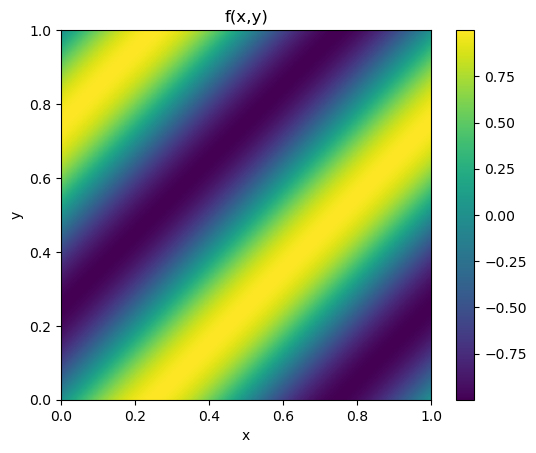

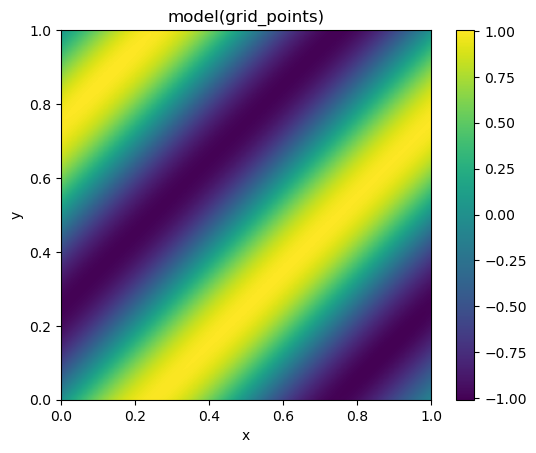

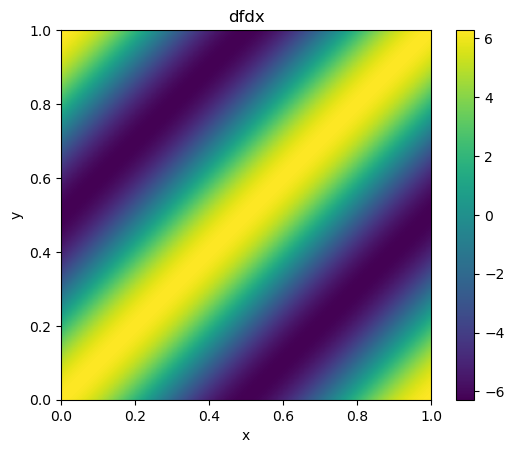

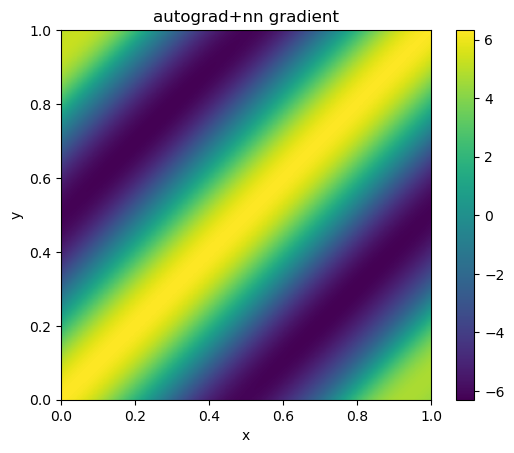

In [131]:
print('f(x,y) = ', f(X, Y))
print('model(grid_points) = ', output1)

mse1 = ((f(X1,Y1) - output1)**2).mean()
print('mse_model = ', mse1)

print('dfdx = ', dfdx(X, Y))
print('autograd+ nn gradient = ', gradient1)

mse2 = ((dfdx(X1, Y1) - gradient1)**2).mean()
print('mse_dfdx = ', mse2)

plt.title('f(x,y)')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(f(X1, Y1), extent=[0,1,0,1])
plt.colorbar()
plt.show()

plt.title('model(grid_points)')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(output1, extent=[0,1,0,1])
plt.colorbar()
plt.show()

plt.title('dfdx')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(dfdx(X1, Y1), extent=[0,1,0,1])
plt.colorbar()
plt.show()

plt.title('autograd+nn gradient')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(gradient1, extent=[0,1,0,1])
plt.colorbar()
plt.show()

target_values =  tensor([[ 0.0000e+00,  2.1012e-02,  4.2016e-02,  ..., -4.2015e-02,
         -2.1012e-02,  1.7485e-07],
        [ 2.1012e-02,  4.2016e-02,  6.3000e-02,  ..., -2.1012e-02,
          1.7485e-07,  2.1013e-02],
        [ 4.2016e-02,  6.3000e-02,  8.3957e-02,  ...,  1.7485e-07,
          2.1013e-02,  4.2016e-02],
        ...,
        [-4.2015e-02, -2.1012e-02,  1.7485e-07,  ..., -8.3957e-02,
         -6.3000e-02, -4.2015e-02],
        [-2.1012e-02,  1.7485e-07,  2.1013e-02,  ..., -6.3000e-02,
         -4.2015e-02, -2.1012e-02],
        [ 1.7485e-07,  2.1013e-02,  4.2016e-02,  ..., -4.2015e-02,
         -2.1012e-02,  3.4969e-07]])
f(x,y) tensor([[ 0.0000e+00,  2.1012e-02,  4.2016e-02,  ..., -4.2015e-02,
         -2.1012e-02,  1.7485e-07],
        [ 2.1012e-02,  4.2016e-02,  6.3000e-02,  ..., -2.1012e-02,
          1.7485e-07,  2.1013e-02],
        [ 4.2016e-02,  6.3000e-02,  8.3957e-02,  ...,  1.7485e-07,
          2.1013e-02,  4.2016e-02],
        ...,
        [-4.2015e-02, 

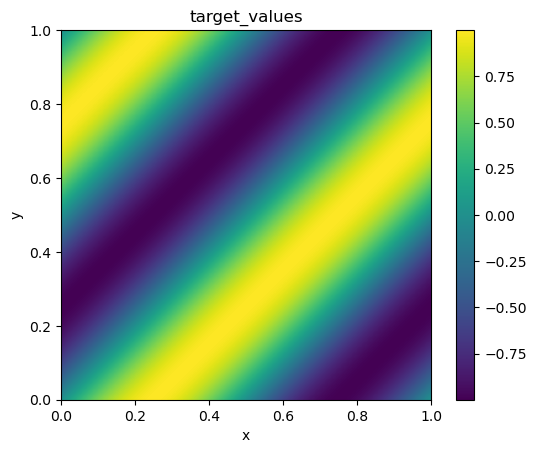

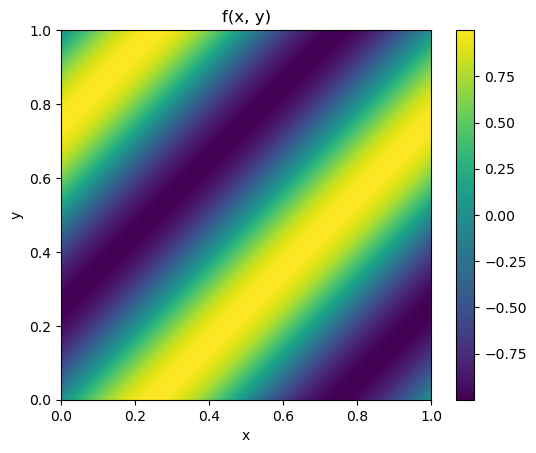

In [126]:
print('target_values = ', target_values.reshape(300,300))
print('f(x,y)', f(X, Y))

plt.title('target_values')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(target_values.reshape(300, 300), extent=[0,1,0,1])
plt.colorbar()
plt.show()

f = f(X, Y).detach().numpy()
plt.title('f(x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(f, extent=[0,1,0,1])
plt.colorbar()
plt.show()

In [58]:
gradient11 = gradient1.numpy()
np.save('x300_nn', gradient11)

x300_nn = np.load('x300_nn.npy')

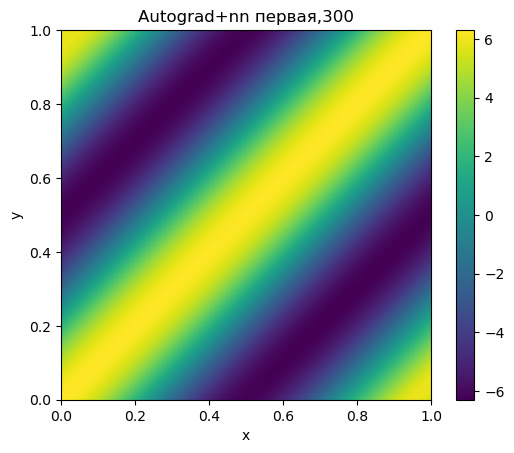

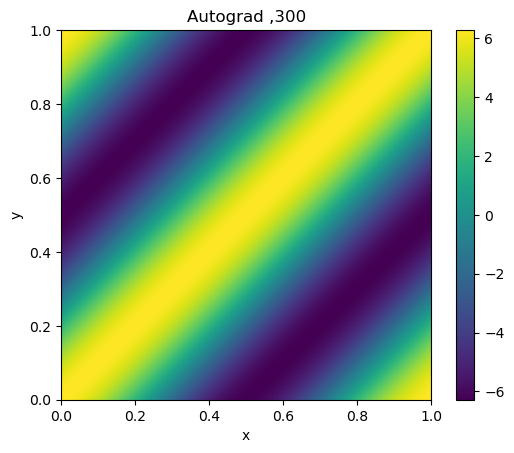

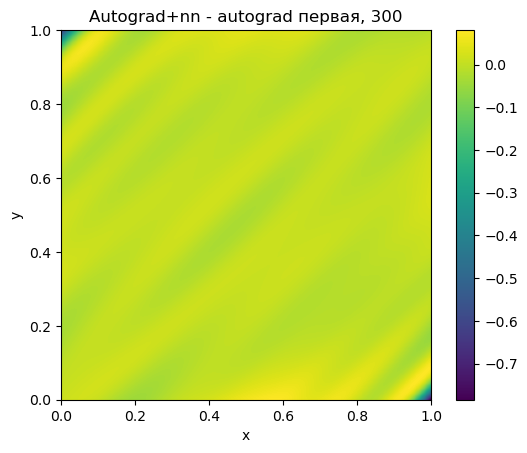

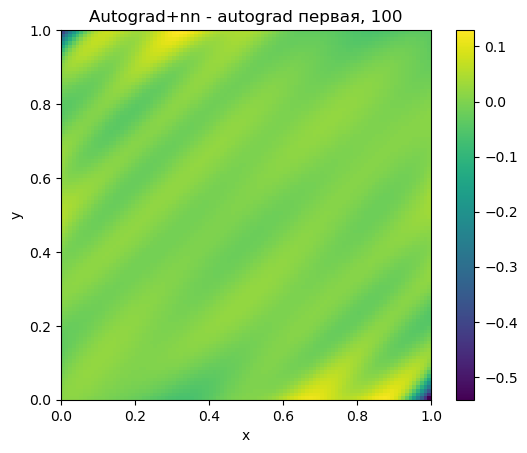

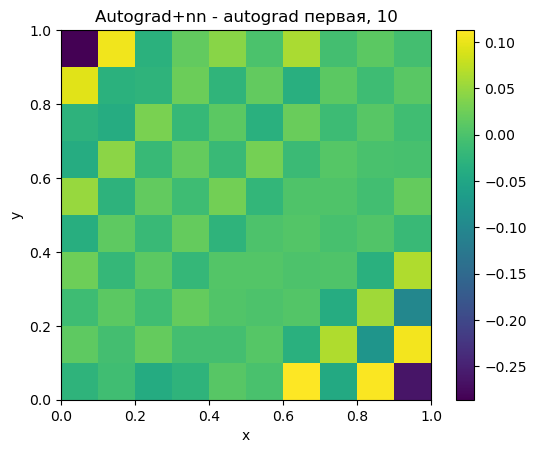

In [95]:
plt.title('Autograd+nn первая,300')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(x300_nn, extent=[0,1,0,1])
plt.colorbar()
plt.show()
plt.title('Autograd ,300')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(x300, extent=[0,1,0,1])
plt.colorbar()
plt.show()
plt.title('Autograd+nn - autograd первая, 300')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(x300_nn - x300, extent=[0,1,0,1])
plt.colorbar()
plt.show()
plt.title('Autograd+nn - autograd первая, 100')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(x100_nn - x100, extent=[0,1,0,1])
plt.colorbar()
plt.show()
plt.title('Autograd+nn - autograd первая, 10')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(x10_nn - x10, extent=[0,1,0,1])
plt.colorbar()
plt.show()

In [96]:
x300 = np.load('x300.npy')
x300_nn = np.load('x300_nn.npy')
mse300 = ((x300 - x300_nn)**2).mean()
print(mse300)

x100 = np.load('x100.npy')
x100_nn = np.load('x100_nn.npy')
mse100 = ((x100 - x100_nn)**2).mean()
print(mse100)

x10 = np.load('x10.npy')
x10_nn = np.load('x10_nn.npy')
mse10 = ((x10 - x10_nn)**2).mean()
print(mse10)



0.0005613067
0.00067592866
0.0027842682
